<a href="https://colab.research.google.com/github/pafernannapi18/GithubIntro/blob/main/Copy_of_31St_Assigen_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [Problem 1] Sharing and executing the official tutorial model

* From the Tensoflow official tutorial models, we have chosen the data augmentation

* From: [TensorFlow](https://www.tensorflow.org/tutorials/images/data_augmentation)


Data augmentation

Overview
This tutorial demonstrates data augmentation: a technique to increase the diversity of your training set by applying random (but realistic) transformations, such as image rotation.

We learned how to apply data augmentation in two ways:

* Use the Keras preprocessing layers, such as tf.keras.layers.Resizing, tf.keras.layers.Rescaling, tf.keras.layers.RandomFlip, and tf.keras.layers.RandomRotation.
* Use the tf.image methods, such as tf.image.flip_left_right, tf.image.rgb_to_grayscale, tf.image.adjust_brightness, tf.image.central_crop, and tf.image.stateless_random*.


Setup

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

Download a dataset

In [ ]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

The flowers dataset has five classes.

In [ ]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


Let's retrieve an image from the dataset and use it to demonstrate data augmentation.

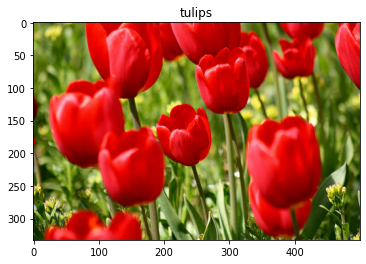

In [ ]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

Use Keras preprocessing layers

Resizing and rescaling

We used the Keras preprocessing layers to resize our images to a consistent shape (with `tf.keras.layers.Resizing`), and to rescale pixel values (with `tf.keras.layers.Rescaling`).

In [ ]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

Note: The rescaling layer above standardizes pixel values to the `[0, 1]` range. If instead you wanted it to be `[-1, 1]`, you would write `tf.keras.layers.Rescaling(1./127.5, offset=-1)`.


You can visualize the result of applying these layers to an image.

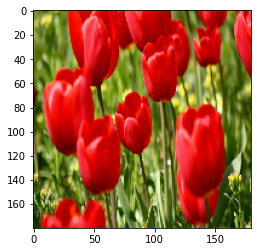

In [ ]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

Verify that the pixels are in the [0, 1] range:

In [ ]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


Data augmentation

You can use the Keras preprocessing layers for data augmentation as well, such as tf.keras.layers.RandomFlip and tf.keras.layers.RandomRotation.

Let's create a few preprocessing layers and apply them repeatedly to the same image.

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [ ]:
# Add the image to a batch.
image = tf.expand_dims(image, 0)

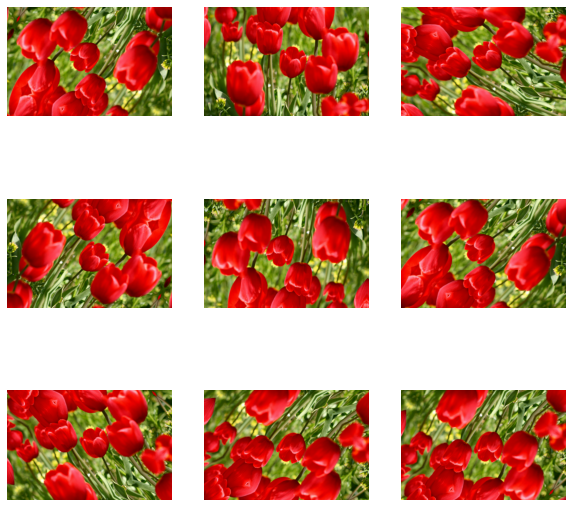

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

Two options to use the Keras preprocessing layers

There are two ways you can use these preprocessing layers, with important trade-offs.

Option 1: Make the preprocessing layers part of your model

In [ ]:
model = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Rest of your model.
])

There are two important points to be aware of in this case:

* Data augmentation will run on-device, synchronously with the rest of your layers, and benefit from GPU acceleration.

* When you export your model using model.save, the preprocessing layers will be saved along with the rest of your model. If you later deploy this model, it will automatically standardize images (according to the configuration of your layers). This can save you from the effort of having to reimplement that logic server-side.

Note: Data augmentation is inactive at test time so input images will only be augmented during calls to Model.fit (not Model.evaluate or Model.predict).

Option 2: Apply the preprocessing layers to your dataset

In [ ]:
aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

With this approach, you use Dataset.map to create a dataset that yields batches of augmented images. In this case:

* Data augmentation will happen asynchronously on the CPU, and is non-blocking. You can overlap the training of your model on the GPU with data preprocessing, using Dataset.prefetch, shown below.
* In this case the preprocessing layers will not be exported with the model when you call Model.save. You will need to attach them to your model before saving it or reimplement them server-side. After training, you can attach the preprocessing layers before export.

Let's demonstrate the second option here.

### Apply the preprocessing layers to the datasets

Configure the training, validation, and test datasets with the Keras preprocessing layers you created earlier. You will also configure the datasets for performance, using parallel reads and buffered prefetching to yield batches from disk without I/O become blocking.

Note: Data augmentation should only be applied to the training set.

In [ ]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

# Train a model

For completeness, we now train a model using the datasets we have just prepared.

The Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu'). This model has not been tuned for accuracy (the goal is to show you the mechanics).

In [ ]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

We choosed the tf.keras.optimizers.Adam optimizer and tf.keras.losses.SparseCategoricalCrossentropy loss function. To view training and validation accuracy for each training epoch, pass the metrics argument to Model.compile.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Train for a few epochs:

In [ ]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
92/92 [==============================] - 104s 1s/step - loss: 1.2905 - accuracy: 0.4465 - val_loss: 1.0600 - val_accuracy: 0.5858
Epoch 2/5
92/92 [==============================] - 99s 1s/step - loss: 1.0523 - accuracy: 0.5834 - val_loss: 1.0798 - val_accuracy: 0.5804
Epoch 3/5
92/92 [==============================] - 102s 1s/step - loss: 0.9630 - accuracy: 0.6209 - val_loss: 0.8970 - val_accuracy: 0.6540
Epoch 4/5
92/92 [==============================] - 101s 1s/step - loss: 0.8928 - accuracy: 0.6567 - val_loss: 0.9135 - val_accuracy: 0.6322
Epoch 5/5
92/92 [==============================] - 99s 1s/step - loss: 0.8628 - accuracy: 0.6635 - val_loss: 0.8379 - val_accuracy: 0.6621


In [ ]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

12/12 [==============================] - 4s 305ms/step - loss: 0.7777 - accuracy: 0.6676
Accuracy 0.667574942111969


## Custom data augmentation

You can also create custom data augmentation layers.

This section of the tutorial shows two ways of doing so:

* First, you will create a tf.keras.layers.Lambda layer. This is a good way to write concise code.
* Next, you will write a new layer via subclassing, which gives you more control.
Both layers will randomly invert the colors in an image, according to some probability.

In [ ]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

In [ ]:
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

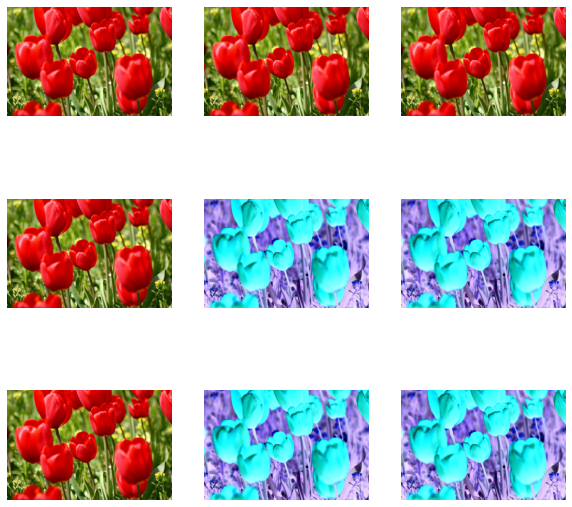

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = random_invert(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

Next, implement a custom layer by subclassing:

In [ ]:
class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)

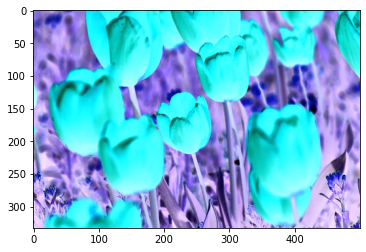

In [ ]:
_ = plt.imshow(RandomInvert()(image)[0])

Both of these layers can be used as described in options 1 and 2 above.

## Using tf.image

The above Keras preprocessing utilities are convenient. But, for finer control, you can write your own data augmentation pipelines or layers using tf.data and tf.image. (You may also want to check out TensorFlow Addons Image: Operations and TensorFlow I/O: Color Space Conversions.)

Since the flowers dataset was previously configured with data augmentation, let's reimport it to start fresh:

In [ ]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

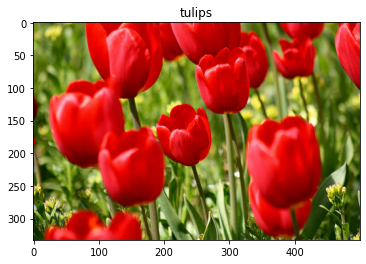

In [ ]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

Let's use the following function to visualize and compare the original and augmented images side-by-side:

In [ ]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

## Data augmentation

Flip an image

Flip an image either vertically or horizontally with tf.image.flip_left_right:

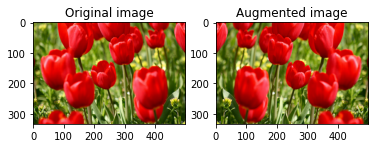

In [ ]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

### Grayscale an image

You can grayscale an image with tf.image.rgb_to_grayscale:

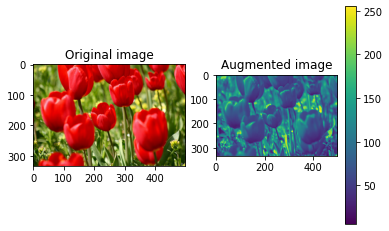

In [ ]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

Saturate an image

Saturate an image with tf.image.adjust_saturation by providing a saturation factor:

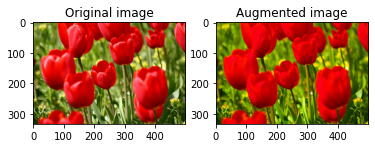

In [ ]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

### Change image brightness

Change the brightness of image with tf.image.adjust_brightness by providing a brightness factor:

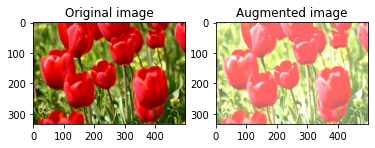

In [ ]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

Center crop an image

Crop the image from center up to the image part you desire using tf.image.central_crop:

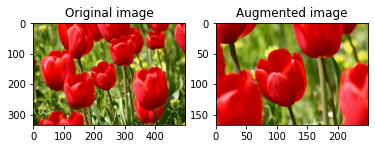

In [ ]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image,cropped)

Rotate an image

Rotate an image by 90 degrees with tf.image.rot90:

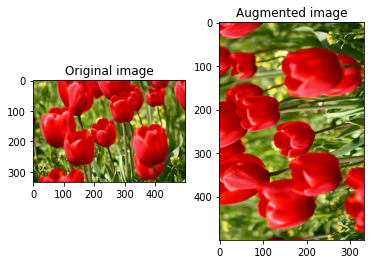

In [ ]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

# Random transformations

Warning: There are two sets of random image operations: tf.image.random* and tf.image.stateless_random*. Using tf.image.random* operations is strongly discouraged as they use the old RNGs from TF 1.x. Instead, please use the random image operations introduced in this tutorial. For more information, refer to Random number generation.

Applying random transformations to the images can further help generalize and expand the dataset. The current tf.image API provides eight such random image operations (ops):

* tf.image.stateless_random_brightness
* tf.image.stateless_random_contrast
* tf.image.stateless_random_crop
* tf.image.stateless_random_flip_left_right
* tf.image.stateless_random_flip_up_down
* tf.image.stateless_random_hue
* tf.image.stateless_random_jpeg_quality
* tf.image.stateless_random_saturation

These random image ops are purely functional: the output only depends on the input. This makes them simple to use in high performance, deterministic input pipelines. They require a seed value be input each step. Given the same seed, they return the same results independent of how many times they are called.

Note: seed is a Tensor of shape (2,) whose values are any integers.

In the following sections, you will:

1. Go over examples of using random image operations to transform an image; and
2. Demonstrate how to apply random transformations to a training dataset.

### Randomly change image brightness
Randomly change the brightness of image using tf.image.stateless_random_brightness by providing a brightness factor and seed. The brightness factor is chosen randomly in the range [-max_delta, max_delta) and is associated with the given seed.

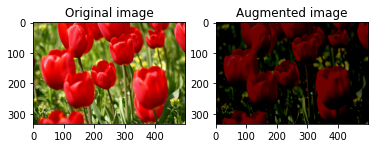

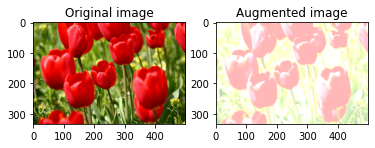

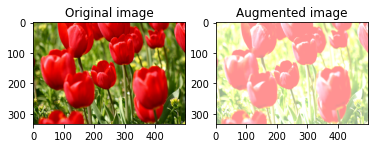

In [ ]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_brightness = tf.image.stateless_random_brightness(
      image, max_delta=0.95, seed=seed)
  visualize(image, stateless_random_brightness)

### Randomly change image contrast
Randomly change the contrast of image using tf.image.stateless_random_contrast by providing a contrast range and seed. The contrast range is chosen randomly in the interval [lower, upper] and is associated with the given seed.

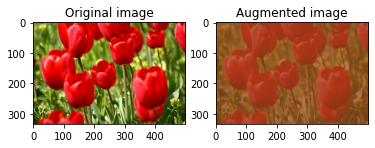

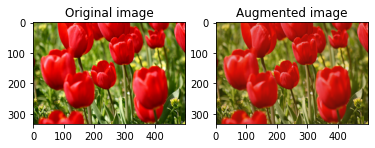

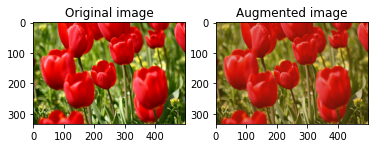

In [ ]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_contrast = tf.image.stateless_random_contrast(
      image, lower=0.1, upper=0.9, seed=seed)
  visualize(image, stateless_random_contrast)

### Randomly crop an image
Randomly crop image using tf.image.stateless_random_crop by providing target size and seed. The portion that gets cropped out of image is at a randomly chosen offset and is associated with the given seed.

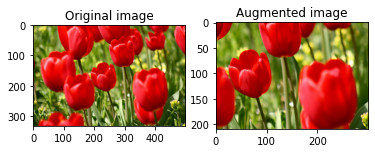

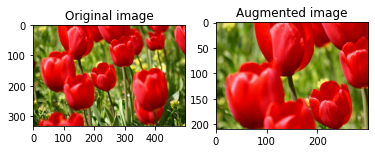

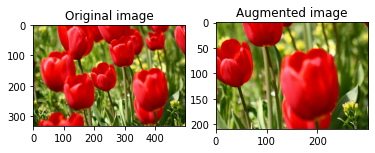

In [ ]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_crop = tf.image.stateless_random_crop(
      image, size=[210, 300, 3], seed=seed)
  visualize(image, stateless_random_crop)

### Apply augmentation to a dataset
Let's first download the image dataset again in case they are modified in the previous sections.

In [ ]:
(train_datasets, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Next, define a utility function for resizing and rescaling the images. This function will be used in unifying the size and scale of images in the dataset:

In [ ]:
def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image, label

Let's also define the augment function that can apply the random transformations to the images. This function will be used on the dataset in the next step.

In [ ]:
def augment(image_label, seed):
  image, label = image_label
  image, label = resize_and_rescale(image, label)
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
  # Make a new seed.
  new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
  # Random crop back to the original size.
  image = tf.image.stateless_random_crop(
      image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed)
  # Random brightness.
  image = tf.image.stateless_random_brightness(
      image, max_delta=0.5, seed=new_seed)
  image = tf.clip_by_value(image, 0, 1)
  return image, label

## Option 1: Using tf.data.experimental.Counter
Create a tf.data.experimental.Counter object (let's call it counter) and Dataset.zip the dataset with (counter, counter). This will ensure that each image in the dataset gets associated with a unique value (of shape (2,)) based on counter which later can get passed into the augment function as the seed value for random transformations.

In [ ]:
# Create a `Counter` object and `Dataset.zip` it together with the trainining set.
counter = tf.data.experimental.Counter()
train_ds = tf.data.Dataset.zip((train_datasets, (counter, counter)))

Map the augment function to the training dataset:

In [ ]:
train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

## Option 2: Using tf.random.Generator
* Create a tf.random.Generator object with an initial seed value. Calling the make_seeds function on the same generator object always returns a new, unique seed value.
* Define a wrapper function that: 1) calls the make_seeds function; and 2) passes the newly generated seed value into the augment function for random transformations.

Note: tf.random.Generator objects store RNG state in a tf.Variable, which means it can be saved as a checkpoint or in a SavedModel. For more details, please refer to Random number generation.

In [ ]:
# Create a generator.
rng = tf.random.Generator.from_seed(123, alg='philox')

In [ ]:
# Create a wrapper function for updating seeds.
def f(x, y):
  seed = rng.make_seeds(2)[0]
  image, label = augment((x, y), seed)
  return image, label

Map the wrapper function f to the training dataset, and the resize_and_rescale function—to the validation and test sets:

In [ ]:
train_ds = (
    train_datasets
    .shuffle(1000)
    .map(f, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

These datasets can now be used to train a model as shown previously.

## [Problem 3] Learning Iris (binary classification) with Keras

Learning Iris (binary classification) with Keras

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam

#Preparing the dataset along with the variables and target
dataset_path ="/content/drive/MyDrive/Iris.csv"
df = pd.read_csv(dataset_path)

df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)

# Convert labels to numbers
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y = y.astype(np.int)[:, np.newaxis]

#Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Further splitting into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [ ]:
#Model building
K.clear_session( )
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation = tf.nn.relu, input_shape=(4,)))
model.add(tf.keras.layers.Dense(100))
model.add(tf.keras.layers.Dense(1, activation = tf.nn.sigmoid))

In [ ]:
model.summary()
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

#Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])

#Train the model
history = model.fit(X_train, y_train,
                    batch_size=10,
                    epochs=10,
                    verbose=1,
                    callbacks=[callback],
                    validation_data=(X_val, y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                250       
                                                                 
 dense_1 (Dense)             (None, 100)               5100      
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 5,451
Trainable params: 5,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 1s 25ms/step - loss: 1.2991 - accuracy: 0.5312 - val_loss: 0.6143 - val_accuracy: 0.5000
Epoch 2/10
7/7 [==============================] - 0s 5ms/step - loss: 0.7459 - accuracy: 0.5625 - val_loss: 0.6233 - val_accuracy: 0.4375
Epoch 3/10
7/7 [=========================

In [ ]:
#Predictions
y_pred_proba = model.predict(X_test)[:, 0]
y_pred = np.where(y_pred_proba >0.5, 1, 0)
print("y_pred_proba", y_pred_proba)
print("y_pred", y_pred)
print('y_test', y_test.ravel())

y_pred_proba [0.07167172 0.9918668  0.04304355 0.99824613 0.9162077  0.9946877
 0.2626351  0.8170854  0.9973588  0.94635034 0.98430586 0.9868749
 0.9962598  0.1834954  0.00822064 0.02731863 0.72415656 0.00867054
 0.9193015  0.02135319]
y_pred [0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 1 0 1 0]
y_test [0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0]


In [ ]:
#Evaluiation of the model
score = model.evaluate(X_test, y_test, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.24461516737937927
Train accuracy: 0.8999999761581421


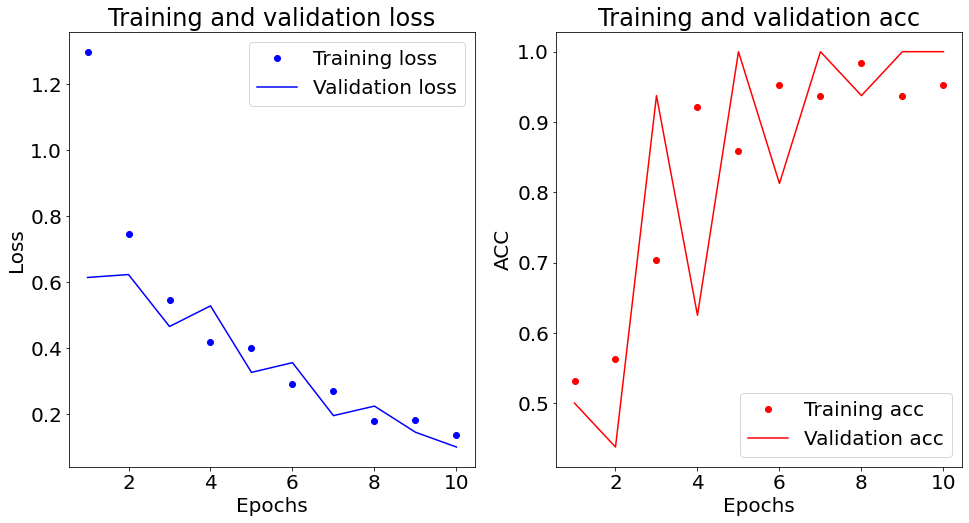

In [ ]:
#Plotting the training and validation loss and accuracy
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)

plt.rcParams["font.size"] = 20
fig = plt.subplots(figsize=(16,8))


plt.subplot(1,2,1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('ACC')
plt.legend()
 
plt.show()

# [Problem 4] Learn Iris (multi-level classification) with Keras

Learning Iris (multi-level classification) with Keras

In [ ]:
#Preparing the dataset along with the variables and target
dataset_path ="/content/drive/MyDrive/Iris.csv"
df = pd.read_csv(dataset_path)

y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)

# Convert labels to numbers
y[y=='Iris-setosa'] = 0
y[y=='Iris-versicolor'] = 1
y[y=='Iris-virginica'] = 2
y = y.astype(np.int)[:, np.newaxis]

#Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Further splitting into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

#Preprocessing / One-hot encoding of correct label value
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train)
y_val_one_hot = enc.transform(y_val)
y_test_one_hot = enc.transform(y_test)

In [ ]:
#Model building
K.clear_session( )
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation = tf.nn.relu, input_shape=(4,)))
model.add(tf.keras.layers.Dense(100))
model.add(tf.keras.layers.Dense(3, activation = tf.nn.softmax))

In [ ]:
model.summary()

#Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])

#Training the model
history = model.fit(X_train, y_train_one_hot,
                    batch_size=10,
                    epochs=10,
                    verbose=0,
                    validation_data=(X_val, y_val_one_hot))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                250       
                                                                 
 dense_1 (Dense)             (None, 100)               5100      
                                                                 
 dense_2 (Dense)             (None, 3)                 303       
                                                                 
Total params: 5,653
Trainable params: 5,653
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Predictions
y_pred_proba = model.predict(X_test)[:, 0]
y_pred = np.where(y_pred_proba >0.5, 1, 0)
print("y_pred_proba", y_pred_proba)
print("y_pred", y_pred)
print('y_test', y_test.ravel())

y_pred_proba [7.1913184e-11 1.1448883e-03 9.9997079e-01 4.6784767e-09 9.9951208e-01
 9.4587456e-13 9.9974626e-01 3.5193423e-04 1.6224739e-04 2.1482392e-03
 8.2694321e-08 7.6177181e-04 2.8533270e-04 2.1067254e-04 2.1357127e-04
 9.9910104e-01 3.0115963e-04 3.4656658e-04 9.9845207e-01 9.9991369e-01
 2.1366894e-08 2.9547053e-04 9.9773204e-01 9.9798191e-01 1.7348182e-05
 9.9992383e-01 9.9895918e-01 1.0836904e-03 8.2888193e-03 9.9885094e-01]
y_pred [0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 0 1]
y_test [2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0]


In [ ]:
#Predictions
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
print("y_pred", y_pred)
print('y_test', y_test.ravel())

y_pred [2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0]
y_test [2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0]


In [ ]:
#Evaluation of the model
score = model.evaluate(X_test, y_test_one_hot, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.025391187518835068
Train accuracy: 1.0


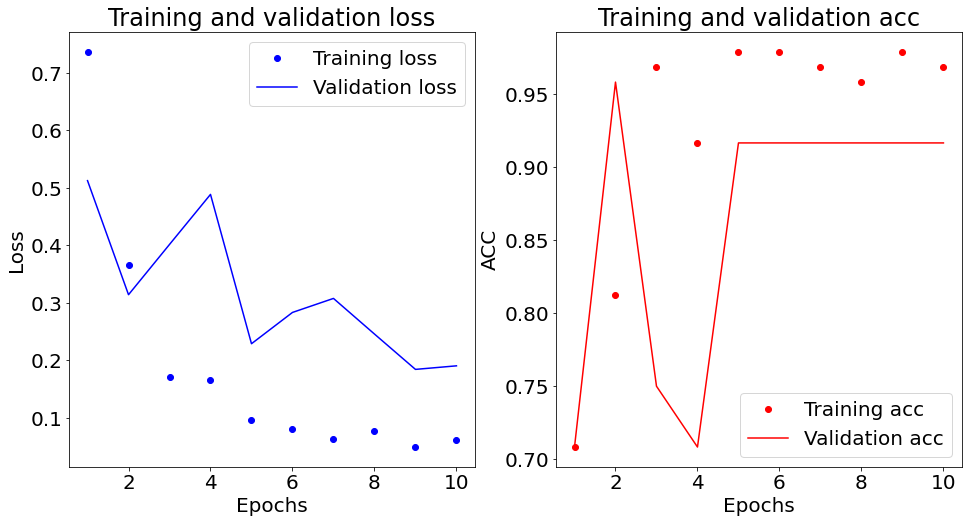

In [ ]:
#Plotting the training and validation loss and accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)

plt.rcParams["font.size"] = 20
fig = plt.subplots(figsize=(16,8))


plt.subplot(1,2,1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('ACC')
plt.legend()
 
plt.show()

# [Problem 5] Learning House Prices with Keras

Learning House Prices with Keras

In [ ]:
from sklearn.preprocessing import StandardScaler

#GEtting the dataset and preparing the variables and target
train = pd.read_csv('/content/drive/MyDrive/Train dataset/train.csv')

x = train[['GrLivArea', 'YearBuilt']]
y = train[['SalePrice']]

#Preparation of the variables and target / Preprocessing
x = np.log(x).values
y = np.log(y).values

sc = StandardScaler()
sc.fit_transform(x)

#Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

#Further splitting into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [ ]:
#Model building
K.clear_session( )
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation = tf.nn.relu, input_shape=(2,)))
model.add(tf.keras.layers.Dense(100))
model.add(tf.keras.layers.Dense(1, activation = tf.keras.activations.linear))

In [ ]:
model.summary()
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

#Compiling the model
model.compile(loss='mse',
              optimizer=tf.optimizers.Adam(learning_rate=0.01),
              metrics=['mse'])

#Training the model
history = model.fit(X_train, y_train,
                    batch_size=10,
                    epochs=20,
                    verbose=1,
                    callbacks=[callback],
                    validation_data=(X_val, y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                150       
                                                                 
 dense_1 (Dense)             (None, 100)               5100      
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 5,351
Trainable params: 5,351
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
94/94 [==============================] - 1s 3ms/step - loss: 2.5294 - mse: 2.5294 - val_loss: 0.0770 - val_mse: 0.0770
Epoch 2/20
94/94 [==============================] - 0s 3ms/step - loss: 0.0758 - mse: 0.0758 - val_loss: 0.0795 - val_mse: 0.0795
Epoch 3/20
94/94 [==============================] - 0s 3ms

In [ ]:
#Predictions
y_pred_proba = model.predict(X_test)
y_pred = y_pred_proba
print("y_pred", y_pred.ravel()[:5])
print('y_test', y_test.ravel()[:5])

y_pred [12.59022  12.171415 11.934428 12.40433  11.85678 ]
y_test [12.20918779 11.79810441 11.60823564 12.16525065 11.38509209]


In [ ]:
#Evaluation of the model
score = model.evaluate(X_test, y_test, verbose=0)
print('loss (test):', score[0])
print('Mean Squared Error (test):', score[1])

loss (test): 0.07328928261995316
Mean Squared Error (test): 0.07328928261995316


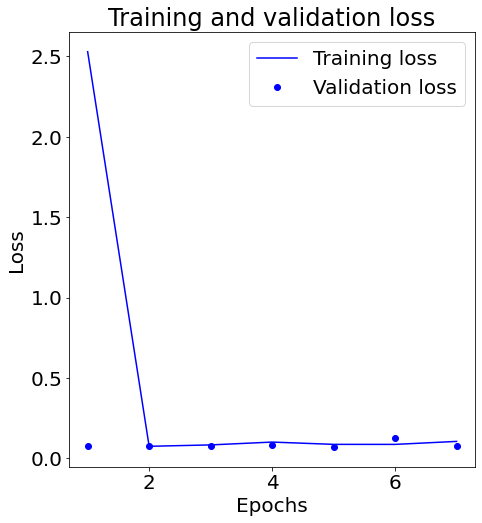

In [ ]:
#Plotting the training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, 8)

plt.rcParams["font.size"] = 20
fig = plt.subplots(figsize=(16,8))

plt.subplot(1,2,1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'b', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
 
plt.show()

# [Problem 6] Learning MNIST with 

Learning MNIST with Keras

In [ ]:
# Download the MNIST dataset
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#flatten
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# Type conversion, normalization
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

#Splitting into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

#Preprocessing of the target variable
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_val_one_hot = enc.transform(y_val[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

In [ ]:
#Model building
K.clear_session( )
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation = tf.nn.relu, input_shape=(784,)))
model.add(tf.keras.layers.Dense(100))
model.add(tf.keras.layers.Dense(10, activation = tf.nn.softmax))

In [ ]:
model.summary()

#Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=0.005),
              metrics=['accuracy'])

#Training the model
history = model.fit(X_train, y_train_one_hot,
                    batch_size=20,
                    epochs=5,
                    verbose=1,
                    validation_data=(X_val, y_val_one_hot))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                39250     
                                                                 
 dense_1 (Dense)             (None, 100)               5100      
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 45,360
Trainable params: 45,360
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
2400/2400 [==============================] - 6s 2ms/step - loss: 0.2937 - accuracy: 0.9127 - val_loss: 0.2699 - val_accuracy: 0.9217
Epoch 2/5
2400/2400 [==============================] - 5s 2ms/step - loss: 0.1869 - accuracy: 0.9464 - val_loss: 0.1868 - val_accuracy: 0.9458
Epoch 3/5
2400/2400 [=========

In [ ]:
#Predictions
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
print("y_pred", y_pred[:10])
print('y_test', y_test.ravel()[:10])

y_pred [7 2 1 0 4 1 4 9 5 9]
y_test [7 2 1 0 4 1 4 9 5 9]


In [ ]:
#Evaluation of the model
score = model.evaluate(X_test, y_test_one_hot, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.17325925827026367
Test accuracy: 0.9556999802589417


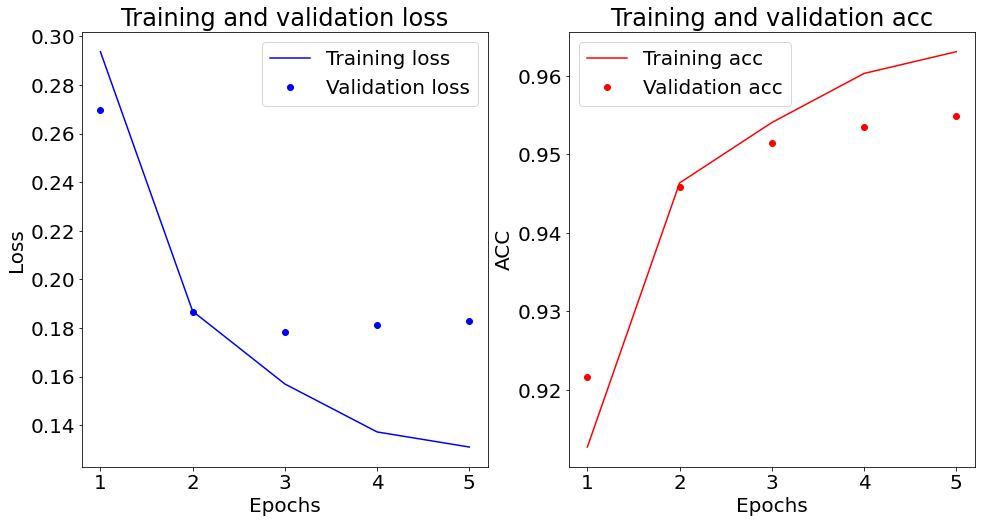

In [ ]:
#Plotting the training and validation loss and accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)

plt.rcParams["font.size"] = 20
fig = plt.subplots(figsize=(16,8))


plt.subplot(1,2,1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'b', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'r', label='Training acc')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'ro', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('ACC')
plt.legend()
 
plt.show()